<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Numerical-Optimization-with-PyTorch" data-toc-modified-id="Numerical-Optimization-with-PyTorch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Numerical Optimization with PyTorch</a></span><ul class="toc-item"><li><span><a href="#Check-PyTorch-Version" data-toc-modified-id="Check-PyTorch-Version-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check PyTorch Version</a></span></li><li><span><a href="#Helper-Functions-For-Plotting/Animating" data-toc-modified-id="Helper-Functions-For-Plotting/Animating-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Helper Functions For Plotting/Animating</a></span></li><li><span><a href="#Defining-Objective-Function-(3-Poles)" data-toc-modified-id="Defining-Objective-Function-(3-Poles)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Defining Objective Function (3-Poles)</a></span></li><li><span><a href="#Gradient-Descent-with-Fixed-Step-Size" data-toc-modified-id="Gradient-Descent-with-Fixed-Step-Size-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Gradient Descent with Fixed Step Size</a></span></li><li><span><a href="#Gradient-Descent-with-Line-Search" data-toc-modified-id="Gradient-Descent-with-Line-Search-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Gradient Descent with Line Search</a></span></li><li><span><a href="#Gradient-Descent-using-Conjugate-Gradients" data-toc-modified-id="Gradient-Descent-using-Conjugate-Gradients-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Gradient Descent using Conjugate Gradients</a></span></li><li><span><a href="#Gradient-Descent-Using-Newton's-Method" data-toc-modified-id="Gradient-Descent-Using-Newton's-Method-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Gradient Descent Using Newton's Method</a></span></li></ul></li></ul></div>

# Numerical Optimization with PyTorch

## Check PyTorch Version

PyTorch 1.8.1 was used for this project. It is needed for the Newton's Method implementation.

In [9]:
import torch
print(torch.__version__)

1.8.1


## Helper Functions For Plotting/Animating

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib nbagg
plt.interactive(False)

# Helper Functions

def plot_f(f, ax=None, optimum_point=None):
    if ax is None:
        ax = plt.gca()
    x1,x2 =  np.mgrid[-1.5:3:.01, -1.5:2:.01]
    X = np.dstack((x1, x2))
    Z = f(X)
    ax.contour(x1, x2, Z, levels=32)
    if optimum_point is not None:
        ax.plot(optimum_point[0], optimum_point[1], "*y")

    
def plot_history(history, linestyle="-k", pointstyle=".r"):
    history = np.array(history)
    p1 = plt.plot(history[:,0], history[:,1], linestyle)
    p2 = plt.plot(history[:,0], history[:,1], pointstyle)
    return p1, p2


def animate_optimization(f, history, linestyle="-k", pointstyle=".r", title=None):
    history_np = np.array(history)
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)
    xdata, ydata = [], []
    p1, = plt.plot([], [], linestyle, alpha=0.5)
    p2, = plt.plot([], [], pointstyle)
    
    if title is not None:
        ax.set_title(title)

    def init():
        return p1, p2,

    def update(frame):
        history_np_until_frame = history_np[:frame+1, :]
        p1.set_data(history_np_until_frame[:,0], history_np_until_frame[:,1])
        p2.set_data(history_np_until_frame[:,0], history_np_until_frame[:,1])
        return p1, p2,

    plot_f(f)
    ani = FuncAnimation(fig, update, frames=len(history_np),
                        init_func=init, blit=True)

    plt.close()
    
    #return ani.to_jshtml()
    return ani.to_html5_video()

_=plt.close()

## Defining Objective Function (3-Poles)

We need two version of the same loss function, one for plotting purposes and another one for PyTorch library.

<ipython-input-11-bb7bf66df5ae>:7: RuntimeWarning: divide by zero encountered in log
  cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)


<IPython.core.display.Javascript object>


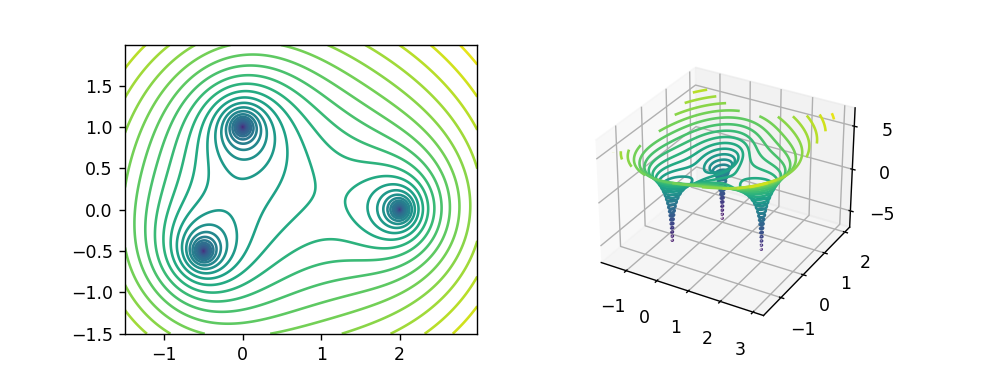

In [11]:
default_poles_numpy = np.array([[2,0], [0,1], [-0.5,-0.5]])
default_poles_torch = torch.tensor(default_poles_numpy)

def f_3poles_numpy(x, xi=default_poles_numpy):
    cum = 0
    for xi_ in xi:
        cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)
    return cum

def f_3poles_torch(x, xi=default_poles_torch):
    cum = 0
    for xi_ in xi:
        cum += torch.log(torch.norm(x-xi_, dim=-1)**2)
    return cum

fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_f(f_3poles_numpy, ax1)
plot_f(f_3poles_numpy, ax2)
fig.show()

## Gradient Descent with Fixed Step Size

In [12]:
def gradient_descent_fixed_step_size(x, loss_function, epoch, step_size):
    history = [x.detach().numpy().copy()]
    for i in range(150):
        loss = loss_function(x)
        loss.backward()

        with torch.no_grad():
            x.copy_(x.data - step_size*x.grad) # update x value

        x.grad.data.zero_() # reset gradients
        history.append(x.detach().numpy().copy())
    return x, history 

x0 = torch.tensor([2., 1.5], requires_grad=True)
step_size = 0.03
epoch = 150
 
x, history = gradient_descent_fixed_step_size(x0, f_3poles_torch, epoch, step_size)
print("Final x:", x)

HTML(animate_optimization(f_3poles_numpy, history, title="Gradient Descent with Fixed Step Size"))

Final x: tensor([-0.4353,  0.1219], requires_grad=True)


<ipython-input-11-bb7bf66df5ae>:7: RuntimeWarning: divide by zero encountered in log
  cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)


## Gradient Descent with Line Search

In [13]:
def gradient_descent_line_search(x, loss_function, epoch, min_step_size, max_step_size, n_steps):
    step_size = torch.linspace(min_step_size, max_step_size, n_steps).reshape(-1, 1)

    history = [x.detach().numpy().copy()]
    for i in range(epoch):
        loss = loss_function(x)
        loss.backward()
        
        with torch.no_grad():
            # line search
            loss = loss_function(x - step_size * x.grad)
            best_step_size = step_size[ np.argmin(loss) ]

            # gradient descent
            x.copy_(x - best_step_size * x.grad) # update x value

            x.grad.data.zero_() # reset gradients
            history.append(x.detach().numpy().copy())
    return x, history


x0 = torch.tensor([2., 1.5], requires_grad=True)
min_step_size = 0
max_step_size = 0.1
n_steps = 100
epoch = 20

x, history = gradient_descent_line_search(x0, f_3poles_torch, epoch, min_step_size, max_step_size, n_steps)
print("Final x:", x)

HTML(animate_optimization(f_3poles_numpy, history, title="Gradient Descent with Line Search"))

Final x: tensor([ 1.9997, -0.0063], requires_grad=True)


<ipython-input-11-bb7bf66df5ae>:7: RuntimeWarning: divide by zero encountered in log
  cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)


## Gradient Descent using Conjugate Gradients

In [14]:
def gradient_descent_conjugate_gradients(x, loss_function, epoch, min_step_size, max_step_size, n_steps, beta_calc="fletcher-reeves"):
    step_size = torch.linspace(min_step_size, max_step_size, n_steps).reshape(-1, 1)

    history = [x.detach().numpy().copy()]
    for i in range(epoch):

        loss = loss_function(x)
        loss.backward()
        dx = x.grad.detach().numpy().copy()

        if i == 0:
            C = dx
        else:
            if beta_calc == "fletcher-reeves":
                beta = min(0, float((dx@dx.T) / (prev_dx@prev_dx.T)))
            elif beta_calc == "polak-ribiere":
                beta = max(0, float(dx@(dx-prev_dx).T / prev_dx@prev_dx.T))
            C = dx + beta*C

        with torch.no_grad():
            # line search
            loss = loss_function(x - step_size * C)
            best_step_size = step_size[ np.argmin(loss) ]

            # gradient descent
            x.copy_(x - best_step_size * C) # update x value

        prev_dx = dx
        x.grad.data.zero_() # reset gradients
        history.append(x.detach().numpy().copy())
        
    return x, history


x0 = torch.tensor([2., 1.5], requires_grad=True)
min_step_size = 0
max_step_size = 0.1
n_steps = 100
epoch = 30
beta_calc = "fletcher-reeves"

x, history = gradient_descent_conjugate_gradients(x0, f_3poles_torch, epoch, min_step_size, max_step_size, n_steps, beta_calc)
print("Final x:", x)

print("Beta is calculated using:", beta_calc)
HTML(animate_optimization(f_3poles_numpy, history, title="Gradient Descent using Conjugate Gradients with fletcher-reeves"))

Final x: tensor([ 1.9997, -0.0063], requires_grad=True)
Beta is calculated using: fletcher-reeves


<ipython-input-11-bb7bf66df5ae>:7: RuntimeWarning: divide by zero encountered in log
  cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)


In [15]:
x0 = torch.tensor([2., 1.5], requires_grad=True)
min_step_size = 0
max_step_size = 0.1
n_steps = 100
epoch = 30
beta_calc = "polak-ribiere"

x, history = gradient_descent_conjugate_gradients(x0, f_3poles_torch, epoch, min_step_size, max_step_size, n_steps, beta_calc)
print("Final x:", x)

print("Beta is calculated using:", beta_calc)
HTML(animate_optimization(f_3poles_numpy, history, title="Gradient Descent using Conjugate Gradients with fletcher-reeves"))

Final x: tensor([ 2.0000, -0.0054], requires_grad=True)
Beta is calculated using: polak-ribiere


<ipython-input-11-bb7bf66df5ae>:7: RuntimeWarning: divide by zero encountered in log
  cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)


## Gradient Descent Using Newton's Method

**Note:** I have used forward/backward method until here, now I will be using derivative methods directly. So we don't need forward/backward/grad cleaning here. I think it is pretty, but this functionality needs PyTorch 1.8.1 and still in Beta according to the docs. 

In [16]:
def gradient_descent_newtons_method(x, loss_function, epoch, step_size):
    
    history = [x.detach().numpy().copy()]
    for i in range(epoch):
        H = torch.autograd.functional.hessian(loss_function, x).detach().numpy()  # Calculate hessian
        J = torch.autograd.functional.jacobian(loss_function, x).detach().numpy() # Calculate jacobian
        
        with torch.no_grad():
            x.copy_(x + step_size * (np.linalg.inv(H) @ J)) # update x value
        
        #x.grad.data.zero_() # reset gradients: not needed here because we used hessian/jacobian functions
        history.append(x.detach().numpy().copy())
    return x, history

x0 = torch.tensor([2., 1.5], requires_grad=True)
step_size = 0.3
epoch = 20

x, history = gradient_descent_newtons_method(x0, f_3poles_torch, epoch, step_size)
print("Final x:", x)

HTML(animate_optimization(f_3poles_numpy, history, title="Gradient Descent Using Newton's Method"))

Final x: tensor([2.0000e+00, 4.5216e-04], requires_grad=True)


<ipython-input-11-bb7bf66df5ae>:7: RuntimeWarning: divide by zero encountered in log
  cum += np.log(np.linalg.norm(x-xi_, axis=-1)**2)
